In [79]:
import os
import sys 

current_directory = os.getcwd()
models_directory = os.path.abspath(os.path.join(current_directory, '..'))
sys.path.append(models_directory)

In [80]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json
import pandas as pd
import seaborn as sns

import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import LogLocator, LogFormatter
from matplotlib.lines import Line2D

# Imports de la libreria propia
from vecopsciml.kernels.derivative import DerivativeKernels
from vecopsciml.utils import TensOps
from vecopsciml.operators import zero_order as zo
from vecopsciml.algebra import zero_order as azo

# Imports de las funciones creadas para este programa
from utils.folders import create_folder
from utils.load_data import load_data
from utils.checkpoints import load_results

from vecopsciml.operators.zero_order import Mx, My

In [81]:
from models.baseline.model import BaselineNonlinearModel
from models.autoencoder.model import Autoencoder, AutoencoderNonlinearModel
from models.fourier.model import FFTNonlinearModel
from models.POD.model import PODNonlinearModel

In [82]:
def smooth_curve(data, window_size=1000):
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, mode='valid')

def cm_to_in(cm):
    return cm * 0.393701

def normalize_list(lst):
    max_value = np.max(lst)
    return [x / max_value for x in lst]

linewidth = 1.5  
title_fontsize = 14  
label_fontsize = 14  
legend_fontsize = 12 
tick_fontsize = 11  

# plt.rc('text', usetex=True)
plt.rc('font', family='serif')

posX = cm_to_in(10) # posición de la esquina inferior izquierda de la imagen en X
posY = cm_to_in(10) # posición de la esquina inferior izquierda de la imagen en Y
width = cm_to_in(12)  # ancho de la imagen
height = cm_to_in(8) # alto de la imagen

color = [0.1, 0, 0.8]  # triplete RGB, valores entre 0 y 1
subplot_adjust_left = cm_to_in(0.15)
subplot_adjust_bottom = cm_to_in(0.15)

In [83]:
data_name = 'non_linear_5000_1'
n_modes = 50

# Creamos los paths para las distintas carpetas
ROOT_PATH = r'/home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning'
DATA_PATH = os.path.join(ROOT_PATH, r'data/', data_name, data_name) + '.pkl'
RESULTS_FOLDER_PATH = os.path.join(ROOT_PATH, r'results/', data_name)
MODEL_RESULTS_PATH = os.path.join(ROOT_PATH, r'results/', data_name, 'baseline_model_') + str(n_modes)

# Creamos las carpetas que sean necesarias (si ya están creadas se avisará de ello)
create_folder(RESULTS_FOLDER_PATH)
create_folder(MODEL_RESULTS_PATH)

Folder already exists at: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/results/non_linear_5000_1
Folder already exists at: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/results/non_linear_5000_1/baseline_model_50


In [84]:
dataset = load_data(DATA_PATH)

# Convolutional filters to derivate
dx = dataset['x_step_size']
dy = dataset['y_step_size']
D = DerivativeKernels(dx, dy, 0).grad_kernels_two_dimensions()

Data successfully loaded from: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/data/non_linear_5000_1/non_linear_5000_1.pkl


In [85]:
def relative_error(validation, prediction, dx=dx, dy=dy):

    # validation = validation.numpy()
    # prediction = prediction.numpy()

    prediction_error = np.sqrt((np.trapz(np.trapz((validation - prediction)**2, dx=dy), dx=dx) /
                                np.trapz(np.trapz((validation)**2, dx=dy), dx=dx)))

    return prediction_error

In [86]:
DEVICE = torch.device("cpu")

In [372]:
N = 10
R = 0
n_modes = 5
data_name = f'non_linear_{N}_{R}'
model_i = 'POD_model_'

mode_i = n_modes

# Creamos los paths para las distintas carpetas
ROOT_PATH = r'/home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning'
DATA_PATH = os.path.join(ROOT_PATH, r'data/', data_name, data_name) + '.pkl'
RESULTS_FOLDER_PATH = os.path.join(ROOT_PATH, r'results/', data_name)
MODEL_RESULTS_PATH = os.path.join(ROOT_PATH, r'results/', data_name, model_i) + str(n_modes)

dataset = load_data(DATA_PATH)

# Train data splitting in train/test
X = torch.tensor(dataset['X_train'], dtype=torch.float32).unsqueeze(1)
y = torch.tensor(dataset['y_train'], dtype=torch.float32).unsqueeze(1)
K = torch.tensor(dataset['k_train'], dtype=torch.float32).unsqueeze(1)
f = torch.tensor(dataset['f_train'], dtype=torch.float32).unsqueeze(1)

X_train, X_test, y_train, y_test, K_train, K_test, f_train, f_test = train_test_split(X, y, K, f, test_size=0.3, random_state=42)

# Data processing and adequacy with our TensOps library
X_train = X_train.to(DEVICE)
X_test = X_test.to(DEVICE)

y_train = TensOps(y_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
y_test = TensOps(y_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

K_train = TensOps(K_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
K_test = TensOps(K_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

f_train = TensOps(f_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
f_test = TensOps(f_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

# Loading and processing validation data
X_val = torch.tensor(dataset['X_val'], dtype=torch.float32).unsqueeze(1)
y_val = TensOps(torch.tensor(dataset['y_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
K_val = TensOps(torch.tensor(dataset['k_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
f_val = TensOps(torch.tensor(dataset['f_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)

# Predictive network architecture
input_shape = X_train[0].shape
predictive_layers = [20, 10, n_modes, 10, 20]
predictive_output = y_train.values[0].shape

# Explanatory network architecture
explanatory_input = Mx(My(y_train)).values[0].shape
explanatory_layers = [10]
explanatory_output = Mx(My(f_train)).values[0].shape

# Other parameters
n_filters_explanatory = 5


if model_i == 'baseline_model_':
    
    color = 'black'

    model = BaselineNonlinearModel(input_shape, predictive_layers, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    model, optimizer, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

elif model_i == 'POD_model_':
    try:
        color = 'green'

        U_train, S_train, Vt_train = torch.linalg.svd(y_train.values.detach().squeeze().to('cpu').view(y_train.values.detach().shape[0], -1), full_matrices=False)
        U_reduced_train = U_train[:, :mode_i]
        S_reduced_train = S_train[:mode_i]
        Vt_reduced_train = Vt_train[:mode_i, :]
        POD_base = Vt_reduced_train.to(DEVICE)
        model = PODNonlinearModel(input_shape, predictive_layers, POD_base, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
        model, optimizer, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

        with open(os.path.join(MODEL_RESULTS_PATH, "time.txt"), "r") as f:
            time_pod = float(f.read().strip())  # Usa float o int según lo que necesites

    except:
        pass
elif model_i == 'FFT_model_':

    color = 'blue'

    model = FFTNonlinearModel(input_shape, predictive_layers, mode_i, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory, device=DEVICE).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    model, optimizer, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

elif model_i == 'model_autoencoder_NN_':

    color = 'red'

    MODEL_RESULTS_AE_PATH = os.path.join(ROOT_PATH, r'results/', data_name, 'model_autoencoder_AE_') + str(n_modes)
    MODEL_RESULTS_PGNNIV_PATH = os.path.join(ROOT_PATH, r'results/', data_name, 'model_autoencoder_NN_') + str(n_modes)

    autoencoder_input_shape = y_train.values[0].shape
    latent_space_dim = [20, 10, n_modes, 10, 20]
    autoencoder_output_shape = y_train.values[0].shape

    autoencoder = Autoencoder(autoencoder_input_shape, latent_space_dim, autoencoder_output_shape).to(DEVICE)
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)

    autoencoder, optimizer, lists = load_results(autoencoder, optimizer, MODEL_RESULTS_AE_PATH, map_location=torch.device('cpu'))

    time_ae = np.cumsum(lists['time_list'])[-1]

    pretrained_encoder = autoencoder.encoder
    pretrained_decoder = autoencoder.decoder

    pgnniv_model = AutoencoderNonlinearModel(input_shape, predictive_layers, pretrained_decoder, predictive_output, explanatory_input,
                                    explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
    optimizer = torch.optim.Adam(pgnniv_model.parameters(), lr=1e-4)

    model, optimizer, lists = load_results(pgnniv_model, optimizer, MODEL_RESULTS_PGNNIV_PATH, map_location=torch.device('cpu'))

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    model, optimizer, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)


else:
    raise ValueError("Not available.")   

Data successfully loaded from: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/data/non_linear_10_0/non_linear_10_0.pkl


In [373]:
u_train = y_train.values.detach().numpy() 
u_predicted_train = model(X_train)[0].detach().numpy() 
er_u_train = relative_error(u_train, u_predicted_train).flatten()

u_val = y_val.values.detach().numpy() 
u_predicted_val = model(X_val)[0].detach().numpy() 
er_u_val = relative_error(u_val, u_predicted_val).flatten()

K_train_ = Mx(My(K_train)).values.detach().numpy() 
K_predicted_train = model(X_train)[1].detach().numpy() 
er_K_train = relative_error(K_train_, K_predicted_train).flatten()

K_val_ = Mx(My(K_val)).values.detach().numpy() 
K_predicted_val = model(X_val)[1].detach().numpy() 
er_K_val = relative_error(K_val_, K_predicted_val).flatten()

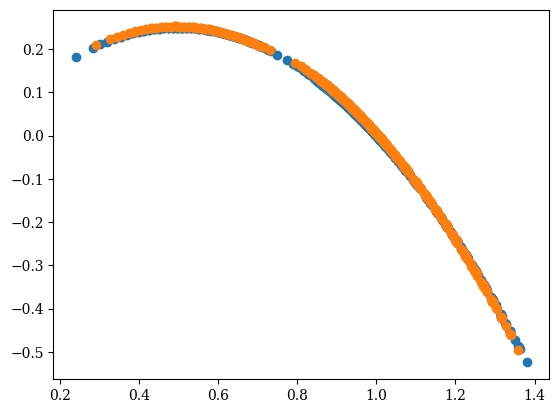

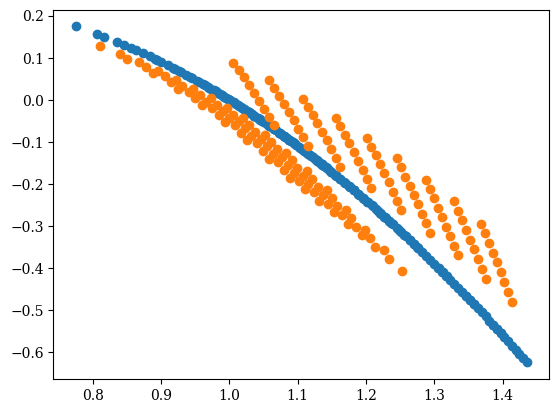

In [382]:
plt.scatter(u_train.flatten(), ((K_train)).values.detach().numpy().flatten())
plt.scatter(Mx(My(y_train)).values.detach().numpy() , K_predicted_train.flatten())
plt.show()

plt.scatter(u_val.flatten(), ((K_val)).values.detach().numpy().flatten())
plt.scatter(Mx(My(y_val)).values.detach().numpy() , K_predicted_val.flatten())
plt.show()

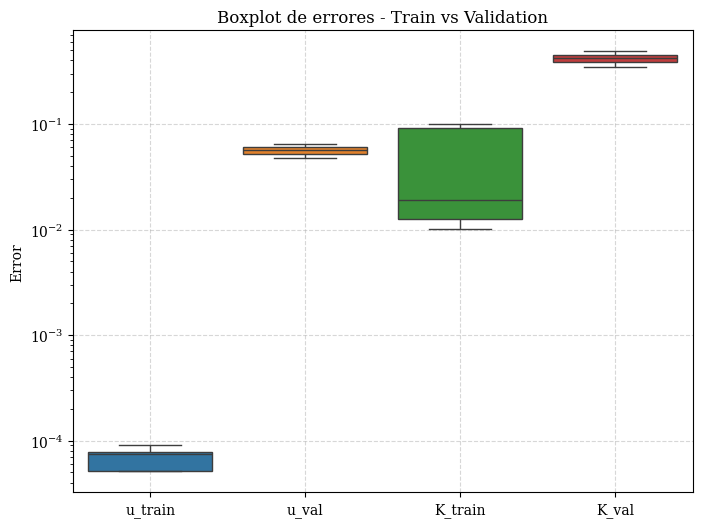

In [376]:
# Crea una figura
plt.figure(figsize=(8, 6))

# Prepara los datos
data = [er_u_train, er_u_val, er_K_train, er_K_val]
labels = ['u_train', 'u_val', 'K_train', 'K_val']

# Dibuja el boxplot
sns.boxplot(data=data)
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.ylabel('Error')
plt.title('Boxplot de errores - Train vs Validation')
plt.grid(True, linestyle='--', alpha=0.5)
plt.yscale('log')

# Muestra el gráfico
plt.show()


# K_predicted_train = model(X_train)[1].detach().numpy() 

# u_predicted_val = model(X_val)[0].detach().numpy() 
# K_predicted_val = model(X_val)[1].detach().numpy() 

# er_u_train = relative_error(u_predicted_train, y_train.values)
# er_K_train = relative_error(K_predicted_train, K_train.values)